## Deezer playlist dataset and music recommendationusing word2vec

In this mini project we will develop a word2vec network and use it to build a playlist completion tool (song suggestion). The data is hosted on the following repository: 
http://github.com/comeetie/deezerplay.git. 
To learn more about word2vec and the data we are going to use you can read the two following references:

- Efficient estimation of word representations in vector space, Tomas Mikolov, Kai Chen, Greg Corrado, and Jeffrey Dean. (https://arxiv.org/abs/1301.3781)
- Word2vec applied to Recommendation: Hyperparameters Matter, H. Caselles-Dupré, F. Lesaint and J. Royo-Letelier. (https://arxiv.org/pdf/1804.04212.pdf)

This project was supervised by Mr. [Etienne Côme, @comeetie](http://github.com/comeetie)

In [4]:
import pandas as pd
import numpy as np
import random
import urllib.request, json
from IPython.display import display, Audio, clear_output
import time
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.neighbors import KDTree
from keras.models import Sequential, Model
from keras.layers import Embedding, Reshape, Activation, Input, Dense,Flatten
from keras.layers.merge import Dot
from keras.utils import np_utils
from keras.preprocessing.sequence import skipgrams

## I. Préparation des données
Les données sont sous la forme d'une liste de playlist. Chaque playlist est elle me une liste avec l'identifiant deezer du morçeau suivi de l'identifiant de l'artiste.

In [5]:
# chargement des données de playlist
data = np.load("./music_2.npy",allow_pickle=True)
[len(data), np.mean([len(p) for p in data])]

[100000, 24.21338]

Le jeu de données sur lequel nous allons trvailler contient 100000 playlist qui sont composeer d'en moyenne 24.1 morceaux. Nous allons commencer par ne conserver que les identifiants de morceau. 

In [6]:
# separation des ids de morçeau et d'artist
playlist_track = [list(filter(lambda w: w.split("_")[0] == "track", playlist)) for playlist in data]
playlist_artist = [list(filter(lambda w: w.split("_")[0] == "artist", playlist)) for playlist in data]

In [7]:
# nombre de morceaux != ?
tracks = np.unique(np.concatenate(playlist_track))
Vt = len(tracks)
Vt

338509

Le nombre de morceaux différents dans ce data-set est assez élevé avec plus de 300 000 morceaux.

## II. Création d'un dictionnnaire de morceau
Nous allons affecter a chaque morceau un entier qui nous servira d'identifiant unique et d'entrée pour notre réseau. Pour économiser un peu nos ressources nous allons travailler dans ce TP que sur les morceaux qui apparaissent dans au moins deux playlists.

In [8]:
# nombre d'occurence de chaque morceaux ?
track_counts = dict((tracks[i],0) for i in range(0, Vt))
for p in playlist_track:
    for a in p:
        track_counts[a]=track_counts[a]+1;

In [9]:
# Filtrage des morceaux peu fréquent pour gangner un peu de temps au vue de nos ressource en temps de calcul  
playlist_track_filter = [list(filter(lambda a : track_counts[a]> 1, playlist)) for playlist in playlist_track]
# recupération des comptage
counts =np.array(list(track_counts.values()))
# trie
order = np.argsort(-counts)
# création de notre liste d'identifiant deezer
tracks_list_ordered = np.array(list(track_counts.keys()))[order]
# Taille de notre vocabulaire = nombre de morçeau conservés
Vt=np.where(counts[order]==1)[0][0]
# construction d'un dict id_morceaux id [0,Vt]
track_dict = dict((tracks_list_ordered[i],i) for i in range(0, Vt))
# conversion des playlist en liste d'entier
corpus_num_track = [[track_dict[track] for track in play ] for play in playlist_track_filter]

## III. Création des ensembles d'apprentissage de test et de validation

Pour apprendre les paramètre de notre méthode nous allons conserver les $l-1$ premiers morceaux de chaque playlist (avec $l$ la longueur de la playlist) pour l'apprentissage. Pour évaluer les performances de completion de notre méthode nous conservons pour chaque playlist les deux derniers morceaux. L'objectif sera de trouver le dernier a partir de l'avant dernier. 



In [10]:
# ensemble de test et d'apprentissage
index_tst = np.random.choice(100000,20000)
index_val = np.setdiff1d(range(100000),index_tst)
# le debut de chaque playlist est conservé pour l'apprentissage
play_app  = [corpus_num_track[i][:(len(corpus_num_track[i])-1)] 
             for i in range(len(corpus_num_track)) if len(corpus_num_track[i])>1]
# les deux derniers élemnts pour le test et la validation
play_tst  = np.array([corpus_num_track[i][(len(corpus_num_track[i])-2):len(corpus_num_track[i])] 
             for i in index_tst if len(corpus_num_track[i])>3])
play_val  = np.array([corpus_num_track[i][(len(corpus_num_track[i])-2):len(corpus_num_track[i])] 
             for i in index_val if len(corpus_num_track[i])>3])[:10000]

### hyper-paramètres de word2vec :

La méthode word2vec fait intervennir un certains nombre d'hyper paramètres. Nous allons les définirs et leurs donner des première valeurs que nous affinerons par la suite:

In [11]:
# dimension de l'espace latent
vector_dim = 30
# taille de la fenêtre de voisinage
window_width = 3
# sur-échantillonage des exemples négatifs
neg_sample = 5
# taille des mini-batch
min_batch_size = 50
# coeff pour la loi de tirage des exemple negatif
samp_coef = 0.5
# coeff pour le subsampling
sub_samp = 0.00001

### Création des tables de probabilité de tirage (lissée) et non lissée

Pour tirer les exmples négatif nous avons besoin des fréquence lissé de chaque morceau dans notre dataset. De même pour sous échantilloner les morceaux très fréquents nous avons besoin des fréquence brutes. Nous allons calculer ces deux vecteurs.

In [12]:
# recupération des comptage
counts = np.array(list(track_counts.values()),dtype='float')[order[:Vt]]
# normalisation
st =  counts/np.sum(counts)
# lissage
st_smooth = np.power(st,samp_coef)
st_smooth = st_smooth/np.sum(st_smooth)

## IV. Visualisation des lois des fréquences brutes et lissées

### Table de probabilités non lissées

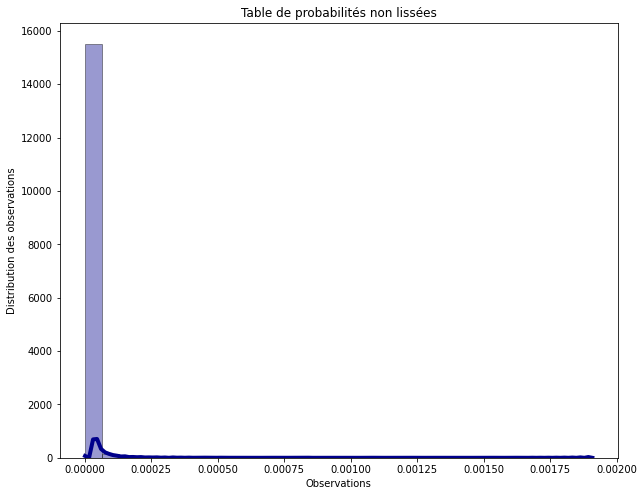

In [36]:
sns.distplot(st, hist=True, kde=True, 
             bins=int(30), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.xlabel("Observations"), plt.ylabel("Distribution des observations") 
plt.title('Table de probabilités non lissées')
plt.show()

### Table de probabilités lissées

Text(0.5, 1.0, 'Table de probabilités lissées')

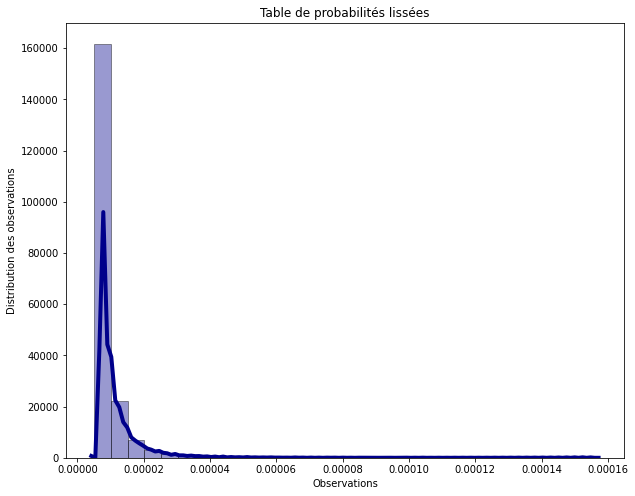

In [37]:
rcParams['figure.figsize'] = 10, 8
sns.distplot(st_smooth, hist=True, kde=True, 
             bins=int(30), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.xlabel("Observations"), plt.ylabel("Distribution des observations") 
plt.title('Table de probabilités lissées')

**Nous ferons à la suite du sur-échantillonnage, un choix de (neg_samples)*(le nombre de paires positives) mots dans le corpus à partir d'une distribution unigramme α-lissée :**
$$
P(c) = \frac{f(c)^{\alpha}}{\sum_{c'}f(c')^{\alpha}}
$$

**Nous ferons aussi un sous-échantillonnage en retirant aléatoirement les mots (sous-échantillonnage) qui sont plus fréquents que certains seuils t avec une probabilité :**
$$
p(c) = \frac{f(c)-t}{f(c)} - \sqrt{\frac{t}{f(c)}}
$$

**où $f(c)$ représente la fréquence du mot c. D'autres méthodes peuvent être utilisées comme une fenêtre (window) dynamique que nous avons choisi de ne pas exploré ici.**

## V. Construction du réseau word2vec

Un réseau word2vec prend en entrée deux entiers correspondant à deux morceaux, ceux-ci sont plonger dans un espace latent de dimension (vector_dim) grâce a une couche de type embedding (vous devrez utilisez la même couche pour projeter les deux morceaux). Une fois ces deux vecteurs extraits le réseau doit calculer leur produit scalaire normaliser appleler cosine distance : 

$$cos(\theta_{ij})=\frac{z_i.z_j}{||z_i||||z_j||}$$ 

Pour réaliser ce traitement vous utiliserez une couche "Dot" pour "dot product". Le modèle utilise ensuite une couche de type sigmoid pour produire la sortie. Cette sortie vaudra 0 lorsque les deux morceaux sont des morceaux tirés aléatoirement dans l'ensemble du jeu de donnée et 1 lorsqu'il aurront était extraits de la même playslist. 

In [13]:
# entrée deux entier (couple de morceaux)
input_target = Input((1,), dtype='int32')
input_context = Input((1,), dtype='int32')

emb = Embedding(input_dim = Vt, output_dim = vector_dim)
Z1 = emb(input_target)
Z2 = emb(input_context)
# a vous de compléter
dot_product = Dot(axes = 2, name = 'dot')([Z1, Z2])
flat = Flatten(name= 'flatten')(dot_product)
output = Dense(1, activation='sigmoid',name="classif")(flat)

# definition du modèle
Track2Vec = Model(inputs=[input_target, input_context], outputs=output)
Track2Vec.compile(loss='binary_crossentropy', optimizer='adam',metrics=["accuracy"])

In [14]:
Track2Vec.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 30)        3697230     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dot (Dot)                       (None, 1, 1)         0           embedding_1[0][0]          

### Création du générateur de données

Pour apprendre la couche de projection au coeur de notre modèle nous allons construire une générateur d'exemples positifs et négatifs de pair de morceaux proche ou aléatoires issues de nos données d'entrainement. La fonction suivante va permettre de générer de tels exemples a partir d'une playlist (seq) fournies en entrées. Cette fonction va tout d'abord construire tout les couples de morceau pouvant être extraient de la séquences s'ils se situent à moins de (windows) disance l'un de l'autres. Ces paires constitueront les paires positives. Les paires concernant deux morceaux très fréquents seront supprimer avec une probabilité qui dépendra de leur fréquences. Enfin un nombre d'exemple négatifs (correpondant neg_samples * nombre d'exemple positif) vont être tirés aléatoirement en utilisant la table de tirage (neg_sampling_table). 

In [14]:
# fonction générant les données associé a une séquence
# seq : séquence d'entrée
# neg_samples : nombre d'exemple négatif générés par example positif
# neg_sampling_table : probabilité de tirage des exemples négatif
# sub sampling_table : probabilité servant a sous échantilloner
# sub_t : paramètre de sous échantillonage
def word2vecSampling(seq,window,neg_samples,neg_sampling_table,sub_sampling_table,sub_t):
    # taille du vocabulaire
    V = len(neg_sampling_table)
    # créations des paires positives a partir de la séquence
    positives = skipgrams(sequence=seq, vocabulary_size=V, window_size=window,negative_samples=0)
    ppairs    = np.array(positives[0])
    # sous échantillonage
    if (ppairs.shape[0]>0):
        f = sub_sampling_table[ppairs[:,0]]
        subprob = ((f-sub_t)/f)-np.sqrt(sub_t/f)
        tokeep = (subprob<np.random.uniform(size=subprob.shape[0])) | (subprob<0)
        ppairs = ppairs[tokeep,:]
    nbneg     = ppairs.shape[0]*neg_samples
    # tirage des paires négatives
    if (nbneg > 0):
        negex     = np.random.choice(V, nbneg, p=neg_sampling_table)
        negexcontext = np.repeat(ppairs[:,0],neg_samples)
        npairs    = np.transpose(np.stack([negexcontext,negex]))
        pairs     = np.concatenate([ppairs,npairs],axis=0)
        labels    = np.concatenate([np.repeat(1,ppairs.shape[0]),np.repeat(0,nbneg)])
        perm      = np.random.permutation(len(labels))
        res = [pairs[perm,:],labels[perm]]
    else:
        res=[[],[]]
    return res

In [15]:
# taille de la fenêtre de voisinage
window = 3
# coeff pour la loi de tirage des exemple negatif
samp_coef = 0.5
# coeff pour le subsampling
sub_t = 0.00001
# probabilité de tirage des exemples négatif
neg_sampling_table = st_smooth
# probabilité servant a sous échantilloner
sub_sampling_table = st
# Taille du vocabulaire
V = Vt
# sur-échantillonage des exemples négatifs
neg_samples = 5

In [16]:
# définition du générateur de couple de morceaux (y=0 <-> aléatoire, y=1 <-> proche dans une playlist)
def track_ns_generator(corpus_num,nbm):
    while 1 :
        # tirage de nbm playlist dans corpus_num
        corpus_reduced = random.sample(corpus_num, nbm)
        # création des données x et y 
        x1=[]
        x2=[]
        y=[]
        k=0
        for seq in corpus_reduced :
            w2v = word2vecSampling(seq,window,neg_samples,neg_sampling_table,sub_sampling_table,sub_t)
            for i in range(len(w2v[0])):
                x1.append(w2v[0][i][0])
                x2.append(w2v[0][i][1])
                y.append(w2v[1][i])
                k+=1
        x1=np.array(x1).reshape(k,)
        x2=np.array(x2).reshape(k,)
        y=np.array(y).reshape(k,)
        
        yield ([x1,x2], y)

## VI. Apprentissage du réseau word2vec


In [24]:
for elt in track_ns_generator(play_app,min_batch_size):
    print(elt)
    break

([array([  932,   553,   553, ..., 16975, 67950,   995]), array([91836, 41343,  9083, ...,   995, 92998, 67950])], array([0, 0, 0, ..., 1, 0, 1]))


In [26]:
type(elt[0][0])

numpy.ndarray

In [16]:
hist=Track2Vec.fit(track_ns_generator(play_app, min_batch_size), steps_per_epoch = 200, epochs = 60)


Epoch 1/60
200/200 [==============================] - 26s 132ms/step - loss: 0.6621 - accuracy: 0.8278
Epoch 2/60
200/200 [==============================] - 26s 132ms/step - loss: 0.6086 - accuracy: 0.8333
Epoch 3/60
200/200 [==============================] - 26s 131ms/step - loss: 0.5664 - accuracy: 0.8334
Epoch 4/60
200/200 [==============================] - 26s 131ms/step - loss: 0.5328 - accuracy: 0.8340
Epoch 5/60
200/200 [==============================] - 27s 133ms/step - loss: 0.5051 - accuracy: 0.8353
Epoch 6/60
200/200 [==============================] - 26s 131ms/step - loss: 0.4797 - accuracy: 0.8389
Epoch 7/60
200/200 [==============================] - 27s 135ms/step - loss: 0.4575 - accuracy: 0.8431
Epoch 8/60
200/200 [==============================] - 26s 132ms/step - loss: 0.4393 - accuracy: 0.8455
Epoch 9/60
200/200 [==============================] - 26s 132ms/step - loss: 0.4219 - accuracy: 0.8496
Epoch 10/60
200/200 [==============================] - 27s 135ms/step - 

## VII. Sauvegarde de l'espace latent
Nous pouvons une fois l'apprentissage effectué sauvegarder la position des morceaux dans l'espace latent avec le code suivant:

In [17]:
# récupérations des positions des morceaux dans l'espace de projection
vectors_tracks = Track2Vec.get_weights()[0]
with open('latent_positions.npy', 'wb') as f:
    np.save(f, vectors_tracks)

Et nous pouvons la recharger avec le code suivant :

In [18]:
vectors_tracks=np.load("latent_positions.npy")

## VIII. Utilisation en complétion et évaluation
Nous pouvons maintenant nous servir de cet espace pour faire des suggestions. 

In [20]:
kdt = KDTree(vectors_tracks, leaf_size=10, metric='euclidean')

In [21]:
def predict_batch(seeds, k, X, kdt):
    recommandations = []
    for track in seeds :
        recommandations.append(kdt.query(vectors_tracks[track:track + 1], k)[1][0])
    return recommandations

In [21]:
indexes = predict_batch(play_val[:,0],10,vectors_tracks,kdt)

In [22]:
def HitatK(tracks_true, tracks_predict) :
    score = 0
    for i in range(len(tracks_true)) :
        if tracks_true[i] in tracks_predict[i] :
            score += 1
    return(score/len(tracks_true))

In [23]:
def NDGCatK(tracks_true, tracks_predict) :
    score = 0
    for i in range(len(tracks_true)) :
        if tracks_true[i] in tracks_predict[i] :
            score += 1/np.log2(np.where(tracks_predict[i] == tracks_true[i])[0][0] + 2)
    return(score/len(tracks_true))

In [24]:
HitatK(play_val[:,1], indexes)

0.1687

In [25]:
NDGCatK(play_val[:,1], indexes)

0.10120715716630804

## IX. Tunning des hyper paramètres




**Plusieurs algorithmes sont disponibles pour l'optimisation des hyper paramètres, notamment des méthodes bayésiennes. Nous avons jugé que ce type d'algorithme seraient trop énergivores même après un passage sur Google Colab. A cause du nombre d'epochs nécessaires et de la taille de l'ensemble de validation nous avons choisi de préparer des listes dont nous allons choisir aléatoirement pendant 10 itérations des valeurs d'hyper paramètres et entraîner notre modèle dessus, uniquement avec 5 epochs, puis calculer les métriques définies précédemment et les stocker dans un DataFrame. Ce processus est similaire à celui d'un Randomized GridSearch.**

### IX. 1. Préparation des listes d'hyper paramètres

In [24]:
# liste sur-échantillonage des exemples négatifs
nmb_list = [50, 100]

# liste taille de la fenêtre de voisinage
window_list = [2, 3, 5]

# liste sur-échantillonage des exemples négatifs
neg_samples_list = [5, 10]

# liste coeff pour le subsampling
sub_t_list = [0.001, 0.0001, 0.00001]

In [25]:
# liste coeff pour la loi de tirage des exemple negatif
st_smooth_list = []
samp_coef_list = [0.25, 0.5, 0.75]
for alpha in samp_coef_list :
    # lissage
    st_smooth = np.power(st, alpha)
    st_smooth = st_smooth/np.sum(st_smooth)
    st_smooth_list.append(list(st_smooth))

In [26]:
# probabilité de tirage des exemples négatif
neg_sampling_table_list = st_smooth_list

### IX. 2. Redéfinition de la fonction track_ns_generator avec les hyer paramètres 

In [27]:
def track_ns_generator_GridSearch(corpus_num, nbm, window, neg_samples, neg_sampling_table, sub_t):
    while 1 :
        # tirage de nbm playlist dans corpus_num
        corpus_reduced = random.sample(corpus_num, nbm)
        # création des données x et y 
        x1=[]
        x2=[]
        y=[]
        k=0
        for seq in corpus_reduced :
            w2v = word2vecSampling(seq, window, neg_samples, neg_sampling_table, sub_sampling_table, sub_t)
            for i in range(len(w2v[0])):
                x1.append(w2v[0][i][0])
                x2.append(w2v[0][i][1])
                y.append(w2v[1][i])
                k+=1
        x1=np.array(x1).reshape(k,)
        x2=np.array(x2).reshape(k,)
        y=np.array(y).reshape(k,)
        
        yield ([x1,x2], y)

### IX. 3. Entraînement des modèles et affichage des résultats

In [32]:
Scores_data = pd.DataFrame()
Scores_data[0] = [i for i in range(7)]
for i in range(10) :    
    nbm = random.sample(nmb_list, 1)[0]
    sub_t = random.sample(sub_t_list, 1)[0]
    neg_sampling_table = random.sample(neg_sampling_table_list, 1)[0]
    neg_samples = random.sample(neg_samples_list, 1)[0]
    window = random.sample(window_list, 1)[0]
    
    Track2Vec = Model(inputs=[input_target, input_context], outputs=output)
    Track2Vec.compile(loss='binary_crossentropy', optimizer='adam',metrics=["accuracy"])
    Track2Vec.fit(track_ns_generator_GridSearch(play_app, nbm, window, neg_samples, neg_sampling_table,
                                                sub_t), steps_per_epoch = 20, epochs = 5)
    vectors_tracks = Track2Vec.get_weights()[0]
    kdt = KDTree(vectors_tracks, leaf_size = 10, metric = 'euclidean')
    indexes = predict_batch(play_tst[:,0], 10, vectors_tracks, kdt)
    Scores_data[i+1] = [nbm, sub_t, samp_coef_list[neg_sampling_table_list.index(neg_sampling_table)],
                       neg_samples, window, HitatK(play_tst[:,1], indexes), NDGCatK(play_tst[:,1], indexes)]

Scores_data = Scores_data.drop(0, axis = 1)
Scores_data = Scores_data.T
Scores_data.columns = ["nbm", "sub_t", "samp_coef", "neg_samples", "window", "HitatK", "NDGCatK"]

Epoch 1/5
20/20 [==============================] - 11s 572ms/step - loss: 0.1429 - accuracy: 0.9485
Epoch 2/5
20/20 [==============================] - 11s 571ms/step - loss: 0.1463 - accuracy: 0.9476
Epoch 3/5
20/20 [==============================] - 11s 560ms/step - loss: 0.1505 - accuracy: 0.9470
Epoch 4/5
20/20 [==============================] - 11s 564ms/step - loss: 0.1429 - accuracy: 0.9496
Epoch 5/5
20/20 [==============================] - 11s 553ms/step - loss: 0.1518 - accuracy: 0.9469
Epoch 1/5
20/20 [==============================] - 12s 593ms/step - loss: 0.1848 - accuracy: 0.9318
Epoch 2/5
20/20 [==============================] - 12s 617ms/step - loss: 0.1765 - accuracy: 0.9346
Epoch 3/5
20/20 [==============================] - 12s 596ms/step - loss: 0.1753 - accuracy: 0.9348
Epoch 4/5
20/20 [==============================] - 12s 618ms/step - loss: 0.1727 - accuracy: 0.9377
Epoch 5/5
20/20 [==============================] - 13s 630ms/step - loss: 0.1669 - accuracy: 0.9391


In [33]:
Scores_data

,nbm,sub_t,samp_coef,neg_samples,window,HitatK,NDGCatK
1,50.0,0.00001,0.25,5.0,3.0,0.179013,0.108190
2,50.0,0.00100,0.25,5.0,5.0,0.180706,0.108836
3,100.0,0.00001,0.50,5.0,5.0,0.181422,0.108791
4,100.0,0.00100,0.25,10.0,5.0,0.183440,0.109622
5,50.0,0.00010,0.75,10.0,5.0,0.182333,0.109339
6,50.0,0.00010,0.75,10.0,5.0,0.184091,0.109917
7,50.0,0.00100,0.50,5.0,3.0,0.186109,0.110856
8,100.0,0.00100,0.50,5.0,5.0,0.187410,0.111286
9,50.0,0.00100,0.25,5.0,2.0,0.189559,0.112054
10,100.0,0.00100,0.75,5.0,2.0,0.188843,0.112015


**Comme l'article scientifique "Word2vec applied to Recommendation: Hyperparameters Matter" le discute, les hyper paramètres pour le word2vec sont choisi en se basant sur d'autres problématiques de recommandations ce qui n'est pas forcément pertinent. En effet, les hyper paramètres sont "data and task dependant". Nous avons choisi cependant de ne pas réentraîner notre modèle vu que les métriques obtenues avant sont satisfaisantes.**

## X. Bonus, un peu de musique

Le fichier TrackArtists contient des méta.données sur les morceaux et les artiste pour un sous ensemble des 300000 morceaux présent dans le dataset. Nous pouvons nous en servir pour recherchez le numéro d'un morceau a partir de son titre:

In [28]:
tr_meta=pd.read_csv("./tracks_proj.csv")
joindf = pd.DataFrame({"id":tracks_list_ordered[:Vt],"index":range(Vt)})
meta = tr_meta.merge(joindf, left_on="id",right_on="id")
meta.set_index("index",inplace=True)
meta[["title","artist_name","preview","id"]].head()

,title,artist_name,preview,id
index,,,,
14086,Alone,Petit Biscuit,http://cdn-preview-8.deezer.com/stream/c-89176...,track_100001884
9768,It Was Always You,Maroon 5,http://cdn-preview-e.deezer.com/stream/c-e24ca...,track_100004586
11888,Unkiss Me,Maroon 5,http://cdn-preview-4.deezer.com/stream/c-42340...,track_100004588
321,Sugar,Maroon 5,http://cdn-preview-b.deezer.com/stream/c-b3342...,track_100004590
12477,Leaving California,Maroon 5,http://cdn-preview-5.deezer.com/stream/c-53dbb...,track_100004592


In [29]:
def find_track(title):
    return meta.loc[meta["title"]==title,:].index[0]

tr=find_track("Hexagone")
tr

19492

## XI. Radio

L'api de deeezer permet de récupérer des informations sur les morceaux du dataset a partit de leur id deezer. Parmis ces infos lorsqu'elle est disponnible une url d'écoute d'un extrait gratuit est fournies.

In [30]:
def gettrackinfo(number):
    track_url =  "https://api.deezer.com/track/{}".format(tracks_list_ordered[number].split("_")[1])
    with urllib.request.urlopen(track_url) as url:
        data = json.loads(url.read().decode())
    return data
track_apidata = gettrackinfo(find_track("Saturne"))
track_apidata

{'id': 137260124,
 'readable': True,
 'title': 'Saturne',
 'title_short': 'Saturne',
 'title_version': '',
 'isrc': 'FR9W11619937',
 'link': 'https://www.deezer.com/track/137260124',
 'share': 'https://www.deezer.com/track/137260124?utm_source=deezer&utm_content=track-137260124&utm_term=0_1610977855&utm_medium=web',
 'duration': 363,
 'track_position': 9,
 'disk_number': 1,
 'rank': 822265,
 'release_date': '2016-12-02',
 'explicit_lyrics': True,
 'explicit_content_lyrics': 1,
 'explicit_content_cover': 0,
 'preview': 'https://cdns-preview-9.dzcdn.net/stream/c-9418740990f339a2532c13b3651cba82-7.mp3',
 'bpm': 90.87,
 'gain': -9.5,
 'available_countries': ['AE',
  'AF',
  'AG',
  'AI',
  'AL',
  'AM',
  'AO',
  'AQ',
  'AR',
  'AS',
  'AT',
  'AU',
  'AZ',
  'BA',
  'BB',
  'BD',
  'BE',
  'BF',
  'BG',
  'BH',
  'BI',
  'BJ',
  'BN',
  'BO',
  'BQ',
  'BR',
  'BT',
  'BV',
  'BW',
  'BY',
  'CA',
  'CC',
  'CD',
  'CF',
  'CG',
  'CH',
  'CI',
  'CK',
  'CL',
  'CM',
  'CO',
  'CR',
  '

Nous pouvons donc nous en servir pour écouter un extrait :

In [31]:
display(Audio(track_apidata["preview"],autoplay=True))

In [32]:
meta.head()

,id,u1,u2,nbo,bpm,duration,gain,release_date,title,album_title,artist_name,preview
index,,,,,,,,,,,,
14086,track_100001884,1.697759,-1.242758,12,116.0,273.0,-10.3,2015-05-25,Alone,Alone,Petit Biscuit,http://cdn-preview-8.deezer.com/stream/c-89176...
9768,track_100004586,6.768007,2.011701,16,103.0,239.0,-8.5,2015-05-15,It Was Always You,V (Deluxe),Maroon 5,http://cdn-preview-e.deezer.com/stream/c-e24ca...
11888,track_100004588,6.676823,1.841525,14,130.0,238.0,-9.0,2015-05-15,Unkiss Me,V (Deluxe),Maroon 5,http://cdn-preview-4.deezer.com/stream/c-42340...
321,track_100004590,6.519435,1.899347,219,119.0,235.0,-9.4,2015-05-15,Sugar,V (Deluxe),Maroon 5,http://cdn-preview-b.deezer.com/stream/c-b3342...
12477,track_100004592,6.808398,1.780942,13,97.0,203.0,-7.9,2015-05-15,Leaving California,V (Deluxe),Maroon 5,http://cdn-preview-5.deezer.com/stream/c-53dbb...


In [33]:
def start_radio(seed, nb_candidates, duration, nbsteps = 20):
    track_apidata = gettrackinfo(seed)
    print(track_apidata["title"])
    display(Audio(track_apidata["preview"], autoplay = True))
    time.sleep(duration)
    clear_output()
    track = seed
    already_played = [track]    
    for i in range(nbsteps):
        try :            
            next_track = random.choice(list(predict_batch([track], nb_candidates, vectors_tracks, kdt)[0]))
            stop = 0
            while (next_track in already_played) & (stop < 20) :
                next_track = random.choice(list(predict_batch([track], nb_candidates, vectors_tracks, kdt)[0]))
                stop += 1
            track = next_track
            track_apidata = gettrackinfo(track)
            print(track_apidata["title"])
            display(Audio(track_apidata["preview"], autoplay = True))
            time.sleep(duration)
            already_played.append(track)
        except :
            print("track not found")
            pass
        clear_output()

In [37]:
start_radio(find_track("Saturne"), 5, 10, 10)